In [1]:
# Important! If not done, the GPU memory stays high and tensorflow due to OOM
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


# Using FGSM to Attack MNIST

FGSM (Fast Gradient Sign Method) is an adversarial method that uses the gradient of the model to add adversarial noise to an image in order to confuse a model. [Cleverhans](https://github.com/tensorflow/cleverhans/) is a library created by Ian Goodfellow that provides some default adversarial attack methods, including FGSM. The library also has methods that wrap models and enables using adversarial examples in training and benchmarking. 

Note: the library is not updated to work with TF2, and TF1 does not work with CUDA 10.1, so luckily there are parts of the library in the `future` module that provide compatibility with TF2.

This notebook is largely adapted from this [example](https://colab.research.google.com/github/andantillon/cleverhans/blob/master/tutorials/future/tf2/notebook_tutorials/mnist_fgsm_tutorial.ipynb) notebook.

In [2]:
# python
import numpy as np
import tensorflow as tf
# plotting
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setup the Model

Note that this model is not convolutional, for simplicity

In [4]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(test_images, test_labels)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 85us/sample - loss: 0.4501 - accuracy: 0.8666 - val_loss: 0.2293 - val_accuracy: 0.9347
Epoch 2/10
48000/48000 [==============================] - 4s 73us/sample - loss: 0.2111 - accuracy: 0.9385 - val_loss: 0.1867 - val_accuracy: 0.9457
Epoch 3/10
48000/48000 [==============================] - 4s 78us/sample - loss: 0.1659 - accuracy: 0.9507 - val_loss: 0.1623 - val_accuracy: 0.9514
Epoch 4/10
48000/48000 [==============================] - 4s 76us/sample - loss: 0.1415 - accuracy: 0.9583 - val_loss: 0.1569 - val_accuracy: 0.9549
Epoch 5/10
48000/48000 [==============================] - 4s 73us/sample - loss: 0.1250 - accuracy: 0.9622 - val_loss: 0.1384 - val_accuracy: 0.9582
Epoch 6/10
48000/48000 [==============================] - 4s 74us/sample - loss: 0.1131 - accuracy: 0.9663 - val_loss: 0.1325 - val_accuracy: 0.9594
Epoch 7/10
48000/48000 [==============================] 

# Attacking the Model

In [5]:
from cleverhans.future.tf2.attacks import fast_gradient_method

In [6]:
#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

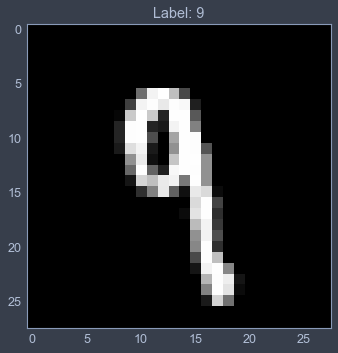

In [23]:
# Pick a random example from the test set
random_index = np.random.randint(test_images.shape[0])

original_image = test_images[random_index]
# Batch size 1
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) 

 # Give label proper shape and type for cleverhans
original_label = test_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64')

plt.figure()
plt.grid(False)
plt.imshow(np.reshape(original_image, (28,28)), cmap='gray')
plt.title("Label: %s"%original_label[0])
plt.show()

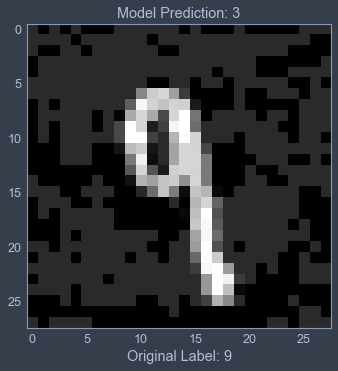

In [24]:
# The value of noise. Lower epsilon means that the image will be closer to being recognizable by a human 
# eye but harder to fool the model. Higher epsilion is easier to fool the model, but harder to stay realistic
epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)


plt.figure()
plt.grid(False)
plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)), cmap='gray')
plt.title("Model Prediction: %s"%np.argmax(adv_example_untargeted_label_pred))
plt.xlabel("Original Label: %s"%original_label[0])
plt.show()

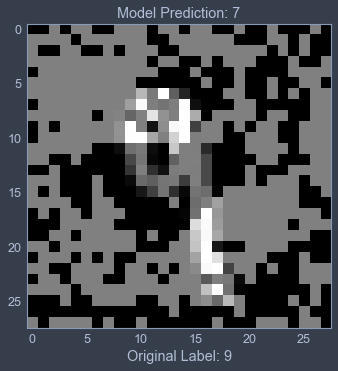

In [30]:
# Trying to "target" an attack
# We specify a label we want to force the model to predict
# Note that since this is harder, the epsilon should be higher
epsilon = 0.5
target = 7

target_label = np.reshape(target, (1,)).astype('int64') 
adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, y=target_label, targeted=True)

adv_example_targeted_label_pred = model.predict(adv_example_targeted_label)

#Show the image
plt.figure()
plt.grid(False)
plt.imshow(np.reshape(adv_example_targeted_label, (28,28)), cmap='gray')
plt.title("Model Prediction: %s"%np.argmax(adv_example_targeted_label_pred))
plt.xlabel("Original Label: %s"%original_label[0])
plt.show()

It is much harder to try and target an attack, even on a simple dataset like MNIST.